### Importing the necessary libraries

In [1]:
!pip install tensorflow==2.15.0 tensorflow-addons==0.21.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 3.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.1.5
    Uninstalling typeguard-4.1.5:
      Successfully uninstalled typeguard-4.1.5
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.
ydata-profiling 4.6.4 requires typeguard<5,>=4.1.2, but you have typeguard 2.13.3 which is incompatible.


# Import Libraries

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Flatten, BatchNormalization, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
import tensorflow_addons as tfa

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.15.0


# Load Data 

In [4]:
import os
from distutils.dir_util import copy_tree

# Define the correct paths based on the directory structure
train_dir = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train'
test_dir = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test'
work_dir = '/kaggle/working/alzheimers_dataset'

# Check if train_dir is valid
if not os.path.exists(train_dir):
    print(f"Path does not exist: {train_dir}")
elif not os.path.isdir(train_dir):
    print(f"Path is not a directory: {train_dir}")
else:
    print(f"Path is valid: {train_dir}")
    # Proceed with copying
    os.makedirs(work_dir, exist_ok=True)
    copy_tree(train_dir, work_dir)
    copy_tree(test_dir, work_dir)
    print("Working Directory Contents:", os.listdir(work_dir))

Path is valid: /kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train
Working Directory Contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


# Data Preprocessing

In [5]:
WORK_DIR = '/kaggle/working/alzheimers_dataset'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [6]:
#Performing Image Augmentation to have more data samples

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


# Display Samples

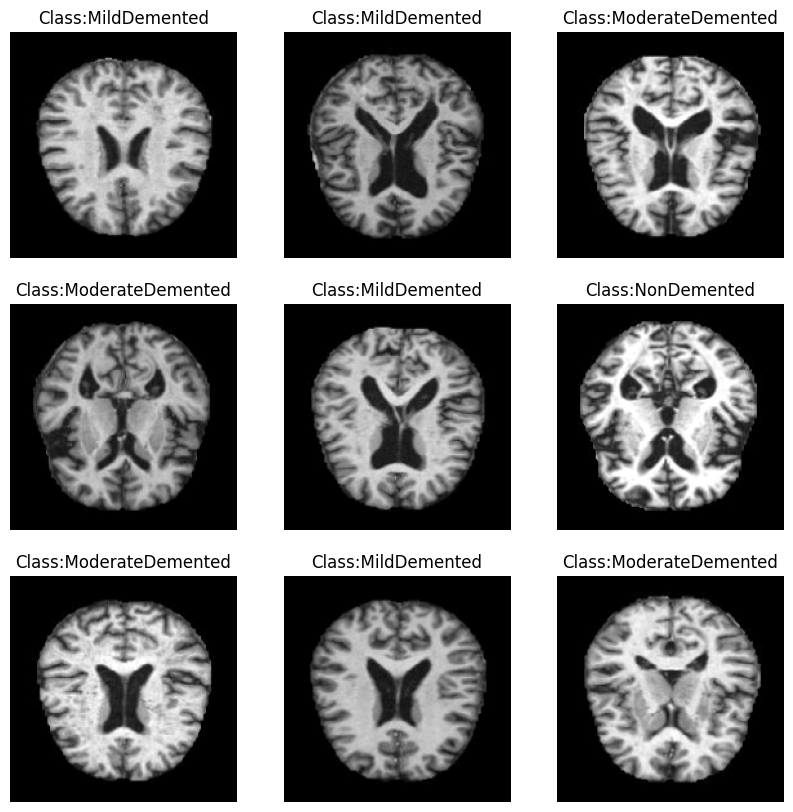

In [7]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

In [7]:
#Retrieving the data from the ImageDataGenerator iterator

train_data, train_labels = train_data_gen.next()

In [8]:
#Getting to know the dimensions of our dataset

print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


In [9]:
#Performing over-sampling of the data, since the classes are imbalanced

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


In [10]:
from sklearn.model_selection import train_test_split

# Assuming `all_data` and `all_labels` contain your entire dataset
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

print(f'Train data shape: {train_data.shape}, Train labels shape: {train_labels.shape}')
print(f'Test data shape: {test_data.shape}, Test labels shape: {test_labels.shape}')


Train data shape: (10240, 176, 176, 3), Train labels shape: (10240, 4)
Test data shape: (2560, 176, 176, 3), Test labels shape: (2560, 4)


# Train Multiple models 

In [11]:
from tensorflow.keras.applications import DenseNet169, MobileNetV2, EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa
import tensorflow as tf

# Define the custom architecture used for all base models
def create_custom_model(base_model):
    for layer in base_model.layers:
        layer.trainable = False
        
    model = Sequential([
        base_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')        
    ], name="custom_cnn_model")
    
    model.compile(optimizer='rmsprop',
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc'),
                           tf.keras.metrics.AUC(name='auc'),
                           tfa.metrics.F1Score(num_classes=4)])
    return model

# DenseNet121 Model
def create_densenet169_model():
    base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(176, 176, 3))
    return create_custom_model(base_model)

# MobileNetV2 Model
def create_mobilenetv2_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(176, 176, 3))
    return create_custom_model(base_model)

# Xception Model
def create_xception_model():
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(176, 176, 3))
    return create_custom_model(base_model)


# Define custom callback to stop training when accuracy exceeds 99%
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True

# Callbacks
my_callback = MyCallback()
rop_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3)
CALLBACKS = [my_callback, rop_callback]

# Create models
densenet169_model = create_densenet169_model()
mobilenetv2_model = create_mobilenetv2_model()
xception_model = create_xception_model()


In [13]:
# Train DenseNet121 Model
history_densenet = densenet169_model.fit(
    train_data,
    train_labels,
    validation_data=(test_data, test_labels),
    epochs=40,
    callbacks=CALLBACKS,
    batch_size=32
)

Epoch 1/40


2024-08-20 11:30:03.165919: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape incustom_cnn_model/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1724153409.202963     154 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


320/320 [==============================] - 55s 118ms/step - loss: 1.2948 - acc: 0.4530 - auc: 0.7146 - f1_score: 0.4482 - val_loss: 0.7372 - val_acc: 0.6578 - val_auc: 0.9000 - val_f1_score: 0.6323 - lr: 0.0010
Epoch 2/40
320/320 [==============================] - 29s 89ms/step - loss: 0.8219 - acc: 0.6288 - auc: 0.8783 - f1_score: 0.6230 - val_loss: 0.6134 - val_acc: 0.7121 - val_auc: 0.9296 - val_f1_score: 0.7100 - lr: 0.0010
Epoch 3/40
320/320 [==============================] - 29s 90ms/step - loss: 0.7048 - acc: 0.6923 - auc: 0.9111 - f1_score: 0.6906 - val_loss: 0.5536 - val_acc: 0.7477 - val_auc: 0.9438 - val_f1_score: 0.7491 - lr: 0.0010
Epoch 4/40
320/320 [==============================] - 29s 91ms/step - loss: 0.6443 - acc: 0.7192 - auc: 0.9260 - f1_score: 0.7183 - val_loss: 0.5121 - val_acc: 0.7594 - val_auc: 0.9512 - val_f1_score: 0.7602 - lr: 0.0010
Epoch 5/40
320/320 [==============================] - 29s 92ms/step - loss: 0.6025 - acc: 0.7436 - auc: 0.9355 - f1_score: 0.7

In [14]:
# Train MobileNetV2 Model
history_mobilenetv2 = mobilenetv2_model.fit(
    train_data,
    train_labels,
    validation_data=(test_data, test_labels),
    epochs=40,
    callbacks=CALLBACKS,
    batch_size=32
)

Epoch 1/40


2024-08-20 11:52:24.486570: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape incustom_cnn_model/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


320/320 [==============================] - 21s 49ms/step - loss: 1.2479 - acc: 0.4661 - auc: 0.7396 - f1_score: 0.4600 - val_loss: 0.7108 - val_acc: 0.6586 - val_auc: 0.9053 - val_f1_score: 0.6253 - lr: 0.0010
Epoch 2/40
320/320 [==============================] - 11s 34ms/step - loss: 0.8042 - acc: 0.6328 - auc: 0.8824 - f1_score: 0.6267 - val_loss: 0.6195 - val_acc: 0.7000 - val_auc: 0.9264 - val_f1_score: 0.7003 - lr: 0.0010
Epoch 3/40
320/320 [==============================] - 11s 34ms/step - loss: 0.6997 - acc: 0.6911 - auc: 0.9121 - f1_score: 0.6898 - val_loss: 0.5666 - val_acc: 0.7297 - val_auc: 0.9393 - val_f1_score: 0.7307 - lr: 0.0010
Epoch 4/40
320/320 [==============================] - 11s 34ms/step - loss: 0.6408 - acc: 0.7184 - auc: 0.9262 - f1_score: 0.7181 - val_loss: 0.5216 - val_acc: 0.7664 - val_auc: 0.9498 - val_f1_score: 0.7689 - lr: 0.0010
Epoch 5/40
320/320 [==============================] - 11s 34ms/step - loss: 0.6061 - acc: 0.7435 - auc: 0.9346 - f1_score: 0.74

In [14]:
# Train Xception Model
xception_model = create_xception_model()
history_xception = xception_model.fit(
    train_data,
    train_labels,
    validation_data=(test_data, test_labels),
    epochs=40,
    callbacks=CALLBACKS,
    batch_size=32
)

Epoch 1/40


2024-08-20 13:17:52.478199: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape incustom_cnn_model/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


320/320 [==============================] - 38s 106ms/step - loss: 1.2911 - acc: 0.4468 - auc: 0.7179 - f1_score: 0.4385 - val_loss: 0.7972 - val_acc: 0.6395 - val_auc: 0.8888 - val_f1_score: 0.6386 - lr: 0.0010
Epoch 2/40
320/320 [==============================] - 31s 97ms/step - loss: 0.8623 - acc: 0.6126 - auc: 0.8652 - f1_score: 0.6070 - val_loss: 0.6810 - val_acc: 0.6855 - val_auc: 0.9141 - val_f1_score: 0.6845 - lr: 0.0010
Epoch 3/40
320/320 [==============================] - 31s 99ms/step - loss: 0.7636 - acc: 0.6614 - auc: 0.8947 - f1_score: 0.6586 - val_loss: 0.6246 - val_acc: 0.7102 - val_auc: 0.9271 - val_f1_score: 0.7034 - lr: 0.0010
Epoch 4/40
320/320 [==============================] - 32s 99ms/step - loss: 0.7067 - acc: 0.6899 - auc: 0.9107 - f1_score: 0.6887 - val_loss: 0.5905 - val_acc: 0.7359 - val_auc: 0.9355 - val_f1_score: 0.7302 - lr: 0.0010
Epoch 5/40
320/320 [==============================] - 32s 101ms/step - loss: 0.6624 - acc: 0.7119 - auc: 0.9212 - f1_score: 0.

# Evaluate Every model on test data

In [17]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf

# Evaluate Models
def evaluate_model_on_cpu(model, test_data, test_labels, model_name):
    with tf.device('/CPU:0'):
        y_pred = model.predict(test_data, batch_size=32)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(test_labels, axis=1)
    
    accuracy = accuracy_score(y_true, y_pred_classes)
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    
    return {
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    }

# Assuming `test_data` and `test_labels` are defined somewhere in your code.
# Use the CPU-based evaluation
densenet_metrics = evaluate_model_on_cpu(densenet169_model, test_data, test_labels, "DenseNet169")
mobilenetv2_metrics = evaluate_model_on_cpu(mobilenetv2_model, test_data, test_labels, "MobileNetV2")
xception_metrics = evaluate_model_on_cpu(xception_model, test_data, test_labels, "Xception")

80/80 [==============================] - 101s 1s/step


# Result summary of Every Model

In [16]:
# Combine results into a DataFrame or any other format as needed
import pandas as pd
from tabulate import tabulate

# Create a DataFrame to display the results
results_df = pd.DataFrame([densenet_metrics, mobilenetv2_metrics, xception_metrics])

# Convert Accuracy to percentage and round off all values
results_df['Accuracy'] = (results_df['Accuracy'] * 100).round(2).astype(str) + '%'
results_df['Precision'] = results_df['Precision'].round(2)
results_df['Recall'] = results_df['Recall'].round(2)
results_df['F1-Score'] = results_df['F1-Score'].round(2)

# Convert DataFrame to a tabulate table
table = tabulate(results_df, headers='keys', tablefmt='pretty', showindex=False)

# Print the table
print(table)

+-------------+----------+-----------+--------+----------+
|    Model    | Accuracy | Precision | Recall | F1-Score |
+-------------+----------+-----------+--------+----------+
| DenseNet169 |  93.75%  |    0.94   |  0.94  |   0.94   |
| MobileNetV2 |  91.37%  |    0.91   |  0.91  |   0.91   |
|   Xception  |  88.24%  |    0.88   |  0.88  |   0.88   |
+-------------+----------+-----------+--------+----------+


# Use DenseNet169 as a Final base model with CNN

In [17]:
from tensorflow.keras.applications import DenseNet169
from sklearn.model_selection import KFold

# Define the base model and custom model architecture
def create_model():
    densenet_model = DenseNet169(input_shape=(176, 176, 3), include_top=False, weights="imagenet")
    for layer in densenet_model.layers:
        layer.trainable = False
    model = Sequential([
        densenet_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')        
    ], name="densenet_cnn_model")
    model.compile(optimizer='rmsprop',
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc'),
                           tf.keras.metrics.AUC(name='auc'),
                           tfa.metrics.F1Score(num_classes=4)])
    return model

# Define custom callback to stop training when accuracy exceeds 99%
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True

my_callback = MyCallback()
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)
CALLBACKS = [my_callback, rop_callback]
EPOCHS = 50


# Cross Validation And Training Process

In [10]:
# Initialize k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
all_histories = []

for train_index, val_index in kf.split(train_data):
    x_train_fold, x_val_fold = train_data[train_index], train_data[val_index]
    y_train_fold, y_val_fold = train_labels[train_index], train_labels[val_index]
    
    model = create_model()
    
    history = model.fit(x_train_fold, y_train_fold,
                        validation_data=(x_val_fold, y_val_fold),
                        callbacks=CALLBACKS,
                        epochs=EPOCHS)
    
    all_histories.append(history.history)

# Aggregate the results from each fold
avg_history = {metric: np.mean([hist[metric] for hist in all_histories], axis=0) for metric in all_histories[0]}


51877672/51877672 [==============================] - 0s 0us/step
Epoch 1/50


2024-08-02 05:39:13.789963: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indensenet_cnn_model/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1722577159.612731     172 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


320/320 [==============================] - 55s 119ms/step - loss: 1.2248 - acc: 0.4667 - auc: 0.7437 - f1_score: 0.4617 - val_loss: 0.6910 - val_acc: 0.6664 - val_auc: 0.9106 - val_f1_score: 0.6392 - lr: 0.0010
Epoch 2/50
320/320 [==============================] - 29s 90ms/step - loss: 0.8092 - acc: 0.6272 - auc: 0.8797 - f1_score: 0.6221 - val_loss: 0.6064 - val_acc: 0.7160 - val_auc: 0.9317 - val_f1_score: 0.7125 - lr: 0.0010
Epoch 3/50
320/320 [==============================] - 30s 92ms/step - loss: 0.7172 - acc: 0.6836 - auc: 0.9074 - f1_score: 0.6806 - val_loss: 0.5448 - val_acc: 0.7543 - val_auc: 0.9469 - val_f1_score: 0.7527 - lr: 0.0010
Epoch 4/50
320/320 [==============================] - 30s 94ms/step - loss: 0.6611 - acc: 0.7134 - auc: 0.9226 - f1_score: 0.7118 - val_loss: 0.5079 - val_acc: 0.7746 - val_auc: 0.9539 - val_f1_score: 0.7740 - lr: 0.0010
Epoch 5/50
320/320 [==============================] - 30s 94ms/step - loss: 0.6151 - acc: 0.7420 - auc: 0.9335 - f1_score: 0.7

2024-08-02 06:04:54.518687: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indensenet_cnn_model/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


320/320 [==============================] - 46s 109ms/step - loss: 1.2903 - acc: 0.4369 - auc: 0.7163 - f1_score: 0.4334 - val_loss: 0.7378 - val_acc: 0.6301 - val_auc: 0.8915 - val_f1_score: 0.6045 - lr: 0.0010
Epoch 2/50
320/320 [==============================] - 30s 94ms/step - loss: 0.8238 - acc: 0.6260 - auc: 0.8766 - f1_score: 0.6218 - val_loss: 0.6294 - val_acc: 0.7074 - val_auc: 0.9256 - val_f1_score: 0.6992 - lr: 0.0010
Epoch 3/50
320/320 [==============================] - 30s 93ms/step - loss: 0.7032 - acc: 0.6834 - auc: 0.9104 - f1_score: 0.6813 - val_loss: 0.5582 - val_acc: 0.7484 - val_auc: 0.9426 - val_f1_score: 0.7443 - lr: 0.0010
Epoch 4/50
320/320 [==============================] - 30s 94ms/step - loss: 0.6533 - acc: 0.7170 - auc: 0.9236 - f1_score: 0.7166 - val_loss: 0.5043 - val_acc: 0.7883 - val_auc: 0.9551 - val_f1_score: 0.7859 - lr: 0.0010
Epoch 5/50
320/320 [==============================] - 30s 93ms/step - loss: 0.6043 - acc: 0.7439 - auc: 0.9347 - f1_score: 0.7

2024-08-02 06:30:34.400014: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indensenet_cnn_model/dropout_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


320/320 [==============================] - 46s 109ms/step - loss: 1.2609 - acc: 0.4579 - auc: 0.7305 - f1_score: 0.4493 - val_loss: 0.6844 - val_acc: 0.6863 - val_auc: 0.9143 - val_f1_score: 0.6740 - lr: 0.0010
Epoch 2/50
320/320 [==============================] - 30s 94ms/step - loss: 0.8052 - acc: 0.6321 - auc: 0.8820 - f1_score: 0.6226 - val_loss: 0.5900 - val_acc: 0.7301 - val_auc: 0.9363 - val_f1_score: 0.7295 - lr: 0.0010
Epoch 3/50
320/320 [==============================] - 30s 93ms/step - loss: 0.7051 - acc: 0.6864 - auc: 0.9107 - f1_score: 0.6800 - val_loss: 0.5427 - val_acc: 0.7590 - val_auc: 0.9461 - val_f1_score: 0.7648 - lr: 0.0010
Epoch 4/50
320/320 [==============================] - 30s 93ms/step - loss: 0.6465 - acc: 0.7177 - auc: 0.9250 - f1_score: 0.7158 - val_loss: 0.4983 - val_acc: 0.7914 - val_auc: 0.9573 - val_f1_score: 0.7949 - lr: 0.0010
Epoch 5/50
320/320 [==============================] - 30s 93ms/step - loss: 0.6085 - acc: 0.7364 - auc: 0.9335 - f1_score: 0.7

2024-08-02 06:56:05.363528: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indensenet_cnn_model/dropout_15/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


320/320 [==============================] - 46s 109ms/step - loss: 1.2842 - acc: 0.4563 - auc: 0.7236 - f1_score: 0.4536 - val_loss: 0.6765 - val_acc: 0.6910 - val_auc: 0.9156 - val_f1_score: 0.6839 - lr: 0.0010
Epoch 2/50
320/320 [==============================] - 30s 94ms/step - loss: 0.8123 - acc: 0.6284 - auc: 0.8793 - f1_score: 0.6260 - val_loss: 0.5808 - val_acc: 0.7375 - val_auc: 0.9378 - val_f1_score: 0.7329 - lr: 0.0010
Epoch 3/50
320/320 [==============================] - 30s 93ms/step - loss: 0.7267 - acc: 0.6755 - auc: 0.9046 - f1_score: 0.6744 - val_loss: 0.5411 - val_acc: 0.7574 - val_auc: 0.9459 - val_f1_score: 0.7559 - lr: 0.0010
Epoch 4/50
320/320 [==============================] - 30s 93ms/step - loss: 0.6533 - acc: 0.7134 - auc: 0.9233 - f1_score: 0.7138 - val_loss: 0.4802 - val_acc: 0.7930 - val_auc: 0.9590 - val_f1_score: 0.7897 - lr: 0.0010
Epoch 5/50
320/320 [==============================] - 30s 93ms/step - loss: 0.6049 - acc: 0.7392 - auc: 0.9347 - f1_score: 0.7

2024-08-02 07:21:27.673838: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indensenet_cnn_model/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


320/320 [==============================] - 46s 109ms/step - loss: 1.3162 - acc: 0.4413 - auc: 0.7096 - f1_score: 0.4358 - val_loss: 0.6969 - val_acc: 0.6781 - val_auc: 0.9099 - val_f1_score: 0.6662 - lr: 0.0010
Epoch 2/50
320/320 [==============================] - 30s 94ms/step - loss: 0.8104 - acc: 0.6237 - auc: 0.8789 - f1_score: 0.6187 - val_loss: 0.5783 - val_acc: 0.7305 - val_auc: 0.9373 - val_f1_score: 0.7248 - lr: 0.0010
Epoch 3/50
320/320 [==============================] - 30s 93ms/step - loss: 0.7072 - acc: 0.6870 - auc: 0.9099 - f1_score: 0.6848 - val_loss: 0.5175 - val_acc: 0.7699 - val_auc: 0.9513 - val_f1_score: 0.7664 - lr: 0.0010
Epoch 4/50
320/320 [==============================] - 30s 93ms/step - loss: 0.6371 - acc: 0.7254 - auc: 0.9279 - f1_score: 0.7261 - val_loss: 0.4804 - val_acc: 0.7875 - val_auc: 0.9585 - val_f1_score: 0.7868 - lr: 0.0010
Epoch 5/50
320/320 [==============================] - 30s 93ms/step - loss: 0.5893 - acc: 0.7432 - auc: 0.9376 - f1_score: 0.7

# Learning Curve

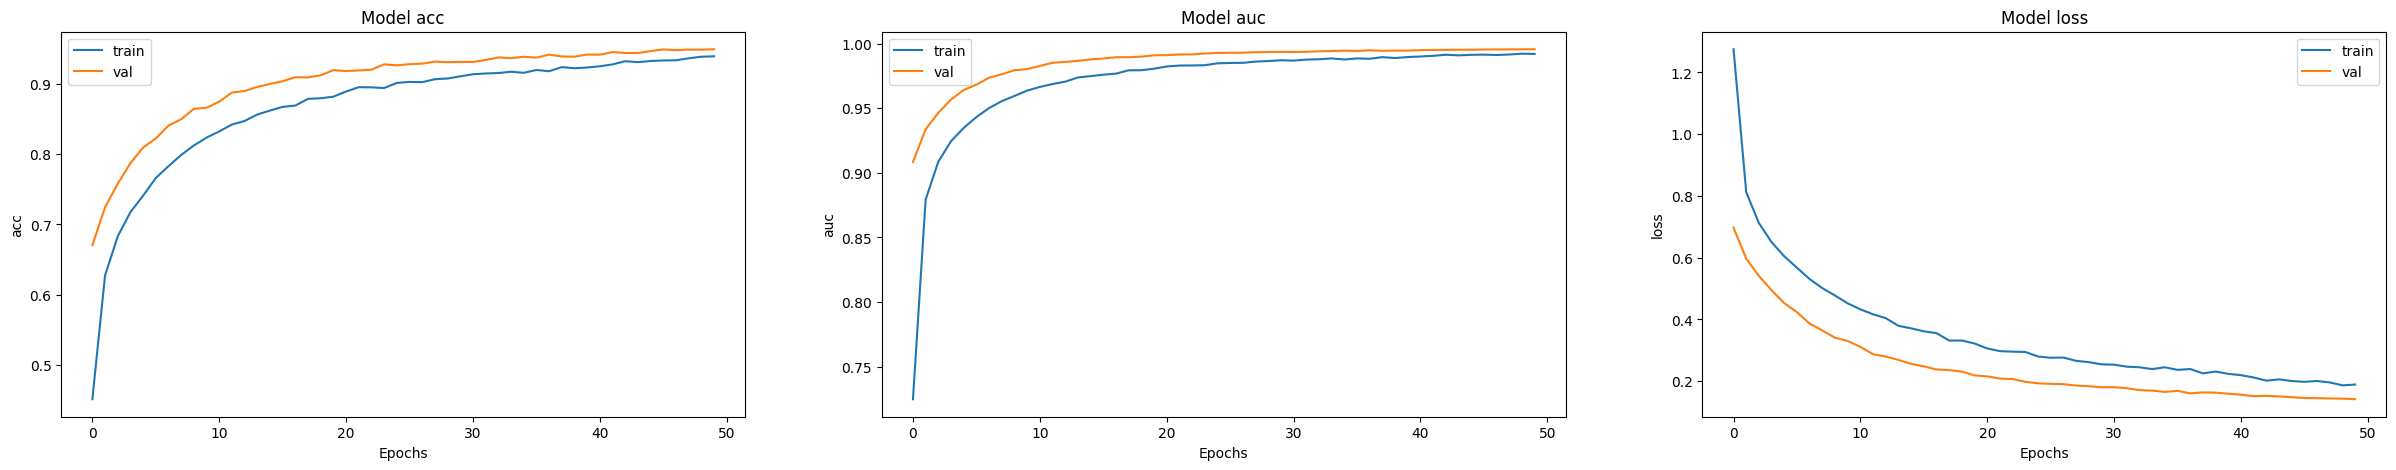

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming avg_history and avg_val_history are available
# Aggregating metrics
metrics = ["acc", "auc", "loss"]

# Plotting the trend of the metrics during training
fig, ax = plt.subplots(1, 3, figsize=(30, 5))
ax = ax.ravel()

for i, metric in enumerate(metrics):
    ax[i].plot(avg_history[metric], label=f"train_{metric}")
    ax[i].plot(avg_history[f"val_{metric}"], label=f"val_{metric}")
    ax[i].set_title(f"Model {metric}")
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

plt.show()


# Classification report on trian data

In [26]:
# Predicting the test data
train_pred_labels = model.predict(test_data)

# Since the labels are softmax arrays, we need to convert to binary (0s and 1s)
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in train_pred_labels:
    labels = roundoff(labels)

# Print the classification report of the tested data
print(classification_report(np.argmax(train_labels, axis=1), np.argmax(train_pred_labels, axis=1)))


320/320 [==============================] - 26s 72ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2561
           1       1.00      0.98      0.99      2565
           2       0.94      0.96      0.95      2538
           3       0.93      0.92      0.92      2576

    accuracy                           0.96     10240
   macro avg       0.96      0.96      0.96     10240
weighted avg       0.96      0.96      0.96     10240



# Classification report on test data

In [16]:
# Predicting the test data
test_pred_labels = model.predict(test_data)

# Since the labels are softmax arrays, we need to convert to binary (0s and 1s)
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in test_pred_labels:
    labels = roundoff(labels)

# Print the classification report of the tested data
print(classification_report(np.argmax(test_labels, axis=1), np.argmax(test_pred_labels, axis=1)))


80/80 [==============================] - 6s 70ms/step
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       639
           1       1.00      0.99      1.00       635
           2       0.96      0.97      0.97       662
           3       0.95      0.95      0.95       624

    accuracy                           0.97      2560
   macro avg       0.97      0.97      0.97      2560
weighted avg       0.97      0.97      0.97      2560



# Confusion Matrix on training data

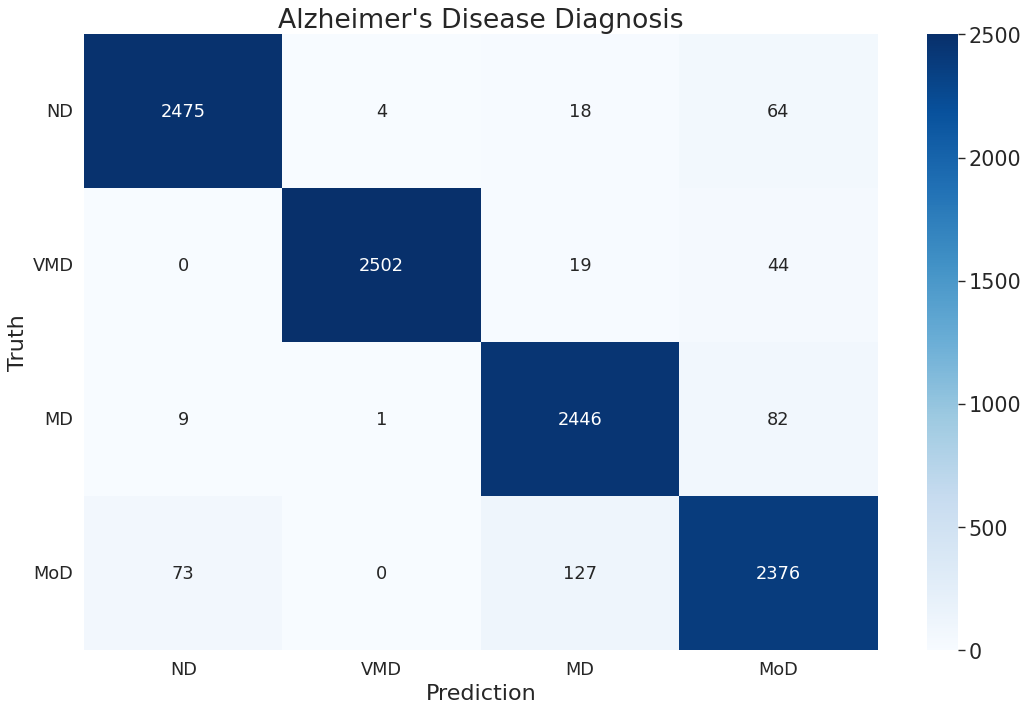

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming pred_labels and test_labels are defined
train_pred_ls = np.argmax(train_pred_labels, axis=1)
train_ls = np.argmax(train_labels, axis=1)

# Generate confusion matrix
conf_arr = confusion_matrix(train_ls, train_pred_ls)

# Define class abbreviations
class_abbr = ['ND', 'VMD', 'MD', 'MoD']

# Set up the plot
plt.figure(figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')

# Increase the font size
sns.set(font_scale=1.7)  # Adjust the font scale as needed

# Plot confusion matrix with increased text size
ax = sns.heatmap(conf_arr, cmap='Blues', annot=True, fmt='d', xticklabels=class_abbr, yticklabels=class_abbr, annot_kws={"size": 16})  # Increase annotation size
plt.title("Alzheimer's Disease Diagnosis", fontsize=24)  # Increase title font size
plt.xlabel("Prediction", fontsize=20)  # Increase x-axis label font size
plt.ylabel("Truth", fontsize=20)  # Increase y-axis label font size
plt.xticks(fontsize=16, rotation=0)  # Increase x-tick labels font size and set rotation to 0 for horizontal
plt.yticks(fontsize=16, rotation=0)  # Increase y-tick labels font size and set rotation to 0
plt.show()

# Confusion Matrix on test data

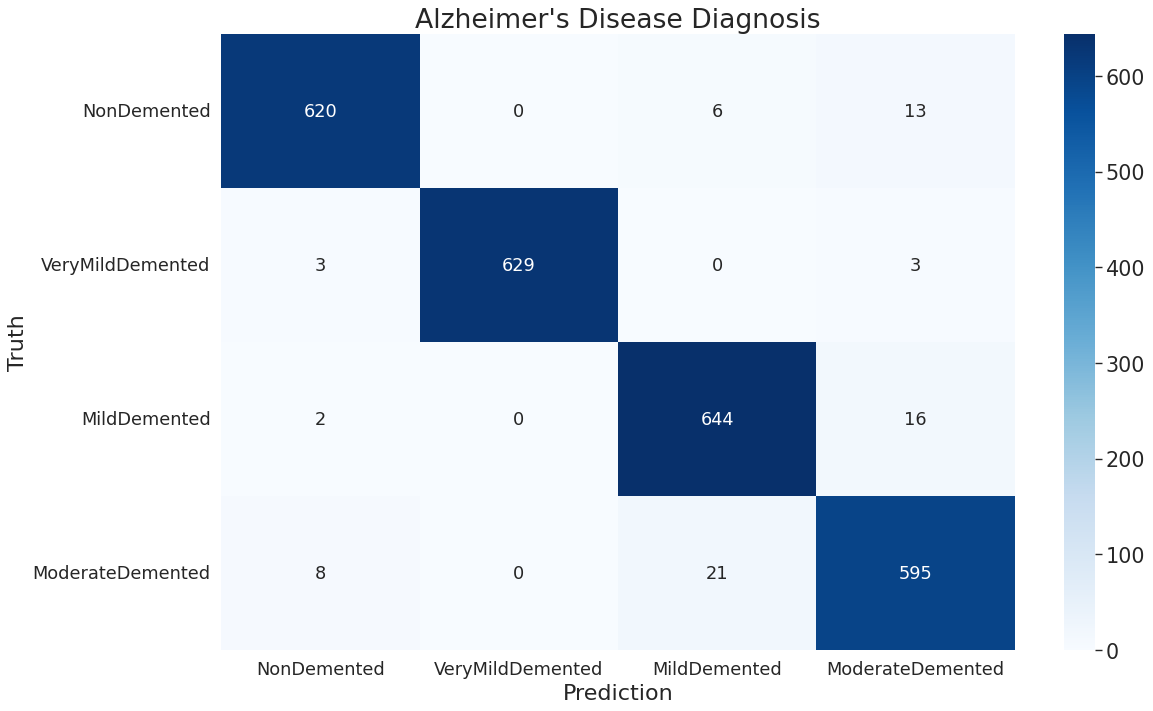

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming pred_labels and test_labels are defined
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

# Generate confusion matrix
conf_arr = confusion_matrix(test_ls, pred_ls)

# Set up the plot
plt.figure(figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')

# Increase the font size
sns.set(font_scale=1.7)  # Adjust the font scale as needed

# Plot confusion matrix with increased text size
ax = sns.heatmap(conf_arr, cmap='Blues', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES, annot_kws={"size": 16})  # Increase annotation size
plt.title("Alzheimer's Disease Diagnosis", fontsize=24)  # Increase title font size
plt.xlabel("Prediction", fontsize=20)  # Increase x-axis label font size
plt.ylabel("Truth", fontsize=20)  # Increase y-axis label font size
plt.xticks(fontsize=16, rotation=0)  # Increase x-tick labels font size and set rotation to 0 for horizontal
plt.yticks(fontsize=16, rotation=0)  # Increase y-tick labels font size and set rotation to 0
plt.show()


# Test Accuracy

In [18]:
#Printing some other classification metrics
print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 97.18 %
Matthew's Correlation Coefficient: 96.25 %


In [21]:
# Saving and loading the model
model.save("alzheimer_densenet_cnn_model")

model_dir = work_dir + "alzheimer_densenet_cnn_model"
model.save(model_dir, save_format='h5')
pretrained_model = tf.keras.models.load_model(model_dir)

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
